# Using Ragas to Evaluate a RAG Application built with LangChain and LangGraph

In the following notebook, we'll be looking at how [Ragas](https://github.com/explodinggradients/ragas) can be helpful in a number of ways when looking to evaluate your RAG applications!

While this example is rooted in LangChain/LangGraph - Ragas is framework agnostic (you don't even need to be using a framework!).

- 🤝 Breakout Room #1
  1. Task 1: Installing Required Libraries
  2. Task 2: Set Environment Variables
  3. Task 3: Synthetic Dataset Generation for Evaluation using Ragas
  4. Task 4: Evaluating our Pipeline with Ragas
  5. Task 6: Making Adjustments and Re-Evaluating

But first! Let's set some dependencies!

## Dependencies and API Keys:

> NOTE: Please skip the pip install commands if you are running the notebook locally.

In [1]:
#!pip install -qU ragas==0.2.10

In [3]:
#!pip install -qU langchain-community==0.3.14 langchain-openai==0.2.14 unstructured==0.16.12 langgraph==0.2.61 langchain-qdrant==0.2.0

We'll also need to provide our API keys.

First, OpenAI's for our LLM/embedding model combination!

In [1]:
import os
from getpass import getpass
os.environ["OPENAI_API_KEY"] = getpass("Please enter your OpenAI API key!")

## Generating Synthetic Test Data

We wil be using Ragas to build out a set of synthetic test questions, references, and reference contexts. This is useful because it will allow us to find out how our system is performing.

> NOTE: Ragas is best suited for finding *directional* changes in your LLM-based systems. The absolute scores aren't comparable in a vacuum.

### Data Preparation

We'll prepare our data - and download our webpages which we'll be using for our data today.

These webpages are from [Simon Willison's](https://simonwillison.net/) yearly "AI learnings".

- [2023 Blog](https://simonwillison.net/2023/Dec/31/ai-in-2023/)
- [2024 Blog](https://simonwillison.net/2024/Dec/31/llms-in-2024/)

Let's start by collecting our data into a useful pile!

In [2]:
!mkdir data

In [3]:
!curl https://simonwillison.net/2023/Dec/31/ai-in-2023/ -o data/2023_llms.html

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31524    0 31524    0     0   188k      0 --:--:-- --:--:-- --:--:--  188k


In [4]:
!curl https://simonwillison.net/2024/Dec/31/llms-in-2024/ -o data/2024_llms.html

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 70549    0 70549    0     0   114k      0 --:--:-- --:--:-- --:--:--  114k


Next, let's load our data into a familiar LangChain format using the `DirectoryLoader`.

In [5]:
from langchain_community.document_loaders import DirectoryLoader

path = "data/"
loader = DirectoryLoader(path, glob="*.html")
docs = loader.load()

### Knowledge Graph Based Synthetic Generation

Ragas uses a knowledge graph based approach to create data. This is extremely useful as it allows us to create complex queries rather simply. The additional testset complexity allows us to evaluate larger problems more effectively, as systems tend to be very strong on simple evaluation tasks.

Let's start by defining our `generator_llm` (which will generate our questions, summaries, and more), and our `generator_embeddings` which will be useful in building our graph.

### Abstracted SDG

The above method is the full process - but we can shortcut that using the provided abstractions!

This will generate our knowledge graph under the hood, and will - from there - generate our personas and scenarios to construct our queries.



In [6]:
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
generator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4.1"))
generator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings())

In [7]:
from ragas.testset import TestsetGenerator

generator = TestsetGenerator(llm=generator_llm, embedding_model=generator_embeddings)
dataset = generator.generate_with_langchain_docs(docs, testset_size=10)

Applying HeadlinesExtractor:   0%|          | 0/2 [00:00<?, ?it/s]

Applying HeadlineSplitter:   0%|          | 0/2 [00:00<?, ?it/s]

Applying SummaryExtractor:   0%|          | 0/2 [00:00<?, ?it/s]

Applying CustomNodeFilter:   0%|          | 0/12 [00:00<?, ?it/s]

Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:   0%|          | 0/26 [00:00<?, ?it/s]

Applying [CosineSimilarityBuilder, OverlapScoreBuilder]:   0%|          | 0/2 [00:00<?, ?it/s]

Generating personas:   0%|          | 0/2 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/12 [00:00<?, ?it/s]

In [16]:
dataset.to_pandas()

,user_input,reference_contexts,reference,synthesizer_name
0,"Which organizations, including Anthropic, have...",[We don’t yet know how to build GPT-4 Vibes Ba...,"A year ago, the only organization that had rel...",single_hop_specifc_query_synthesizer
1,What are some challenges associated with evalu...,[I’m surprised that no-one has beaten the now ...,Evaluating GPT-4 is challenging because there ...,single_hop_specifc_query_synthesizer
2,"what is AI mean now, is it just LLMs or more, ...",[Simon Willison’s Weblog Subscribe Stuff we fi...,AI now often refers to Large Language Models (...,single_hop_specifc_query_synthesizer
3,"me AI product manager, i look at analytics, i ...",[Microsoft over this issue. The 69 page PDF is...,"In the context provided, Plausible refers to P...",single_hop_specifc_query_synthesizer
4,What are the key advantages of using synthetic...,[<1-hop>\n\nThe rise of inference-scaling “rea...,Synthetic training data offers several direct ...,multi_hop_abstract_query_synthesizer
5,Given the rapid advancements in large language...,[<1-hop>\n\nThe rise of inference-scaling “rea...,"The context reveals that in 2024, significant ...",multi_hop_abstract_query_synthesizer
6,how ai model trainin get more better for envir...,[<1-hop>\n\nThe rise of inference-scaling “rea...,ai model trainin got better for environment bu...,multi_hop_abstract_query_synthesizer
7,What are some of the ethical and environmental...,[<1-hop>\n\nThe rise of inference-scaling “rea...,The training and deployment of large language ...,multi_hop_abstract_query_synthesizer
8,Why people keep using ChatGPT even though it s...,[<1-hop>\n\nI’m surprised that no-one has beat...,People keep using ChatGPT even though it somet...,multi_hop_specific_query_synthesizer
9,Considering the dramatic reduction in LLM pric...,[<1-hop>\n\non a story about the town's histor...,Google’s Gemini 1.5 Flash 8B model exemplifies...,multi_hop_specific_query_synthesizer


In [57]:
dataset

Testset(samples=[TestsetSample(eval_sample=SingleTurnSample(user_input='Which organizations, including Anthropic, have produced large language models that are considered better-than-GPT-3 class, and how has the landscape changed since only OpenAI had released a generally useful LLM?', retrieved_contexts=None, reference_contexts=['We don’t yet know how to build GPT-4 Vibes Based Development LLMs are really smart, and also really, really dumb Gullibility is the biggest unsolved problem Code may be the best application The ethics of this space remain diabolically complex My blog in 2023 Here’s the sequel to this post: Things we learned about LLMs in 2024. Large Language Models In the past 24-36 months, our species has discovered that you can take a GIANT corpus of text, run it through a pile of GPUs, and use it to create a fascinating new kind of software. LLMs can do a lot of things. They can answer questions, summarize documents, translate from one language to another, extract informati

In [20]:
dataset.to_pandas().iloc[11]['reference_contexts']


['<1-hop>\n\nI’m surprised that no-one has beaten the now almost year old GPT-4 by now. OpenAI clearly have some substantial tricks that they haven’t shared yet. Vibes Based Development As a computer scientist and software engineer, LLMs are infuriating. Even the openly licensed ones are still the world’s most convoluted black boxes. We continue to have very little idea what they can do, how exactly they work and how best to control them. I’m used to programming where the computer does exactly what I tell it to do. Prompting an LLM is decidedly not that! The worst part is the challenge of evaluating them. There are plenty of benchmarks, but no benchmark is going to tell you if an LLM actually “feels” right when you try it for a given task. I find I have to work with an LLM for a few weeks in order to get a good intuition for it’s strengths and weaknesses. This greatly limits how many I can evaluate myself! The most frustrating thing for me is at the level of individual prompting. Somet

In [21]:
dataset.to_pandas().iloc[11]['reference']


'People say ChatGPT is both smart and dumb because sometimes it does things nobody expected, which is fun, but other times you have to do silly things to get it to work right, like offering it cash tips or telling it your career depends on it. This makes it hard to know if ChatGPT is good for coding or not because it can hallucinate code that doesn’t exist, but for code, you can run it and see if it works, so hallucination is less of a problem. Still, evaluating ChatGPT is hard because you have to use it for weeks to get a feel for its strengths and weaknesses, and there’s no good way to know if small prompt changes really help. This causes problems for people trying to use ChatGPT for real work because it’s hard to control, it’s gullible (believes what you tell it), and there’s no robust way to stop prompt injection or other security issues. So, while ChatGPT can be very useful, especially for code, it’s also unpredictable and needs careful handling to avoid mistakes.'

## LangChain RAG

Now we'll construct our LangChain RAG, which we will be evaluating using the above created test data!

### R - Retrieval

Let's start with building our retrieval pipeline, which will involve loading the same data we used to create our synthetic test set above.

> NOTE: We need to use the same data - as our test set is specifically designed for this data.

In [22]:
path = "data/"
loader = DirectoryLoader(path, glob="*.html")
docs = loader.load()

Now that we have our data loaded, let's split it into chunks!

In [23]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
split_documents = text_splitter.split_documents(docs)
len(split_documents)

75

#### ❓ Question: 

What is the purpose of the `chunk_overlap` parameter in the `RecursiveCharacterTextSplitter`?

1 - Preserve context across chunks.

2 - Avoid cutting off important information that appears at the boundary between two chunks.

3 - Improve downstream tasks like document retrieval, summarization, or question answering, where maintaining context is crucial.

Next up, we'll need to provide an embedding model that we can use to construct our vector store.

In [24]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

Now we can build our in memory QDrant vector store.

In [25]:
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams

client = QdrantClient(":memory:")

client.create_collection(
    collection_name="ai_across_years",
    vectors_config=VectorParams(size=1536, distance=Distance.COSINE),
)

vector_store = QdrantVectorStore(
    client=client,
    collection_name="ai_across_years",
    embedding=embeddings,
)

/home/spdhnes/AIE6/08_Evaluating_RAG_With_Ragas/.venv/lib/python3.13/site-packages/qdrant_client/http/models/models.py:758: SyntaxWarning: invalid escape sequence '\&'
  description="Check that the field is empty, alternative syntax for `is_empty: \&quot;field_name\&quot;`",
/home/spdhnes/AIE6/08_Evaluating_RAG_With_Ragas/.venv/lib/python3.13/site-packages/qdrant_client/http/models/models.py:762: SyntaxWarning: invalid escape sequence '\&'
  description="Check that the field is null, alternative syntax for `is_null: \&quot;field_name\&quot;`",


We can now add our documents to our vector store.

In [26]:
_ = vector_store.add_documents(documents=split_documents)

Let's define our retriever.

In [27]:
retriever = vector_store.as_retriever(search_kwargs={"k": 5})

Now we can produce a node for retrieval!

In [28]:
# def retrieve(state):
#   retrieved_docs = retriever.invoke(state["question"])
#   return {"context" : retrieved_docs}

### Augmented

Let's create a simple RAG prompt!

In [29]:
from langchain.prompts import ChatPromptTemplate

RAG_PROMPT = """\
You are a helpful assistant who answers questions based on provided context. You must only use the provided context, and cannot use your own knowledge.

### Question
{question}

### Context
{context}
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_PROMPT)

### Generation

We'll also need an LLM to generate responses - we'll use `gpt-4o-mini` to avoid using the same model as our judge model.

In [30]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

Then we can create a `generate` node!

In [27]:
# def generate(state):
#   docs_content = "\n\n".join(doc.page_content for doc in state["context"])
#   messages = rag_prompt.format_messages(question=state["question"], context=docs_content)
#   response = llm.invoke(messages)
#   return {"response" : response.content}

### Building RAG Graph with LangGraph

Let's create some state for our LangGraph RAG graph!

In [31]:
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict
from langchain_core.documents import Document

class State(TypedDict):
  question: str
  context: List[Document]
  response: str

In [32]:
def retrieve(state):
  retrieved_docs = retriever.invoke(state["question"])
  return {"context" : retrieved_docs}

In [50]:
def generate(state):
  docs_content = "\n\n".join(doc.page_content for doc in state["context"])
  RA_in_propmt = rag_prompt.format_messages(question=state["question"], context=docs_content)
  G_in_rag = llm.invoke(RA_in_propmt)
  return {"response" : G_in_rag.content}

Now we can build our simple graph!

> NOTE: We're using `add_sequence` since we will always move from retrieval to generation. This is essentially building a chain in LangGraph.

In [52]:
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

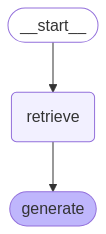

In [53]:
graph

Let's do a test to make sure it's doing what we'd expect.

In [54]:
response = graph.invoke({"question" : "How are LLM agents useful?"})

In [55]:
response

{'question': 'How are LLM agents useful?',
 'context': [Document(metadata={'source': 'data/2024_llms.html', '_id': 'a11f37979cdd4ed7a18828e5bf1595d3', '_collection_name': 'ai_across_years'}, page_content='The two main categories I see are people who think AI agents are obviously things that go and act on your behalf—the travel agent model—and people who think in terms of LLMs that have been given access to tools which they can run in a loop as part of solving a problem. The term “autonomy” is often thrown into the mix too, again without including a clear definition.\n\n(I also collected 211 definitions on Twitter a few months ago—here they are in Datasette Lite—and had gemini-exp-1206 attempt to summarize them.)\n\nWhatever the term may mean, agents still have that feeling of perpetually “coming soon”.\n\nTerminology aside, I remain skeptical as to their utility based, once again, on the challenge of gullibility. LLMs believe anything you tell them. Any systems that attempts to make me

In [56]:
response["response"]

"LLM agents are considered useful for several reasons, despite some skepticism around their utility. Here are the main points derived from the provided context:\n\n1. **Acting on Behalf of Users**: Some view LLM agents as digital assistants that can perform tasks or make decisions for users, similar to a travel agent. This model suggests that LLMs can simplify various processes by handling requests autonomously.\n\n2. **Tool Utilization**: LLMs can be equipped with access to various tools, enabling them to execute functions in a loop to address specific problems. This capability allows them to be more interactive and effective in problem-solving.\n\n3. **Ease of Development**: The surprisingly straightforward process of building LLMs—requiring only a few hundred lines of Python code—means that they are becoming more accessible. While not trivial, the barriers to entry are decreasing compared to earlier expectations.\n\n4. **Running on Personal Devices**: Advances have made it feasible 

## Evaluating the App with Ragas

Now we can finally do our evaluation!

We'll start by running the queries we generated usign SDG above through our application to get context and responses.

In [58]:
for test_row in dataset:
  response = graph.invoke({"question" : test_row.eval_sample.user_input})
  test_row.eval_sample.response = response["response"]
  test_row.eval_sample.retrieved_contexts = [context.page_content for context in response["context"]]

In [59]:
dataset.to_pandas()

,user_input,retrieved_contexts,reference_contexts,response,reference,synthesizer_name
0,"Which organizations, including Anthropic, have...","[If you can gather the right data, and afford ...",[We don’t yet know how to build GPT-4 Vibes Ba...,The organizations that have produced large lan...,"A year ago, the only organization that had rel...",single_hop_specifc_query_synthesizer
1,What are some challenges associated with evalu...,[This is a huge advantage for open over closed...,[I’m surprised that no-one has beaten the now ...,Some challenges associated with evaluating GPT...,Evaluating GPT-4 is challenging because there ...,single_hop_specifc_query_synthesizer
2,"what is AI mean now, is it just LLMs or more, ...",[The two main categories I see are people who ...,[Simon Willison’s Weblog Subscribe Stuff we fi...,AI today encompasses more than just LLMs (Larg...,AI now often refers to Large Language Models (...,single_hop_specifc_query_synthesizer
3,"me AI product manager, i look at analytics, i ...","[The top five: ai (342), generativeai (300), l...",[Microsoft over this issue. The 69 page PDF is...,"In the provided context, ""Plausible"" refers to...","In the context provided, Plausible refers to P...",single_hop_specifc_query_synthesizer
4,What are the key advantages of using synthetic...,[One of the best descriptions I’ve seen of thi...,[<1-hop>\n\nThe rise of inference-scaling “rea...,The key advantages of using synthetic training...,Synthetic training data offers several direct ...,multi_hop_abstract_query_synthesizer
5,Given the rapid advancements in large language...,"[Since then, almost every major LLM (and most ...",[<1-hop>\n\nThe rise of inference-scaling “rea...,The rapid advancements in large language model...,"The context reveals that in 2024, significant ...",multi_hop_abstract_query_synthesizer
6,how ai model trainin get more better for envir...,[Law is not ethics. Is it OK to train models o...,[<1-hop>\n\nThe rise of inference-scaling “rea...,"When considering the training of AI models, pa...",ai model trainin got better for environment bu...,multi_hop_abstract_query_synthesizer
7,What are some of the ethical and environmental...,[Law is not ethics. Is it OK to train models o...,[<1-hop>\n\nThe rise of inference-scaling “rea...,The training and deployment of large language ...,The training and deployment of large language ...,multi_hop_abstract_query_synthesizer
8,Why people keep using ChatGPT even though it s...,[How should we feel about this as software eng...,[<1-hop>\n\nI’m surprised that no-one has beat...,People continue to use ChatGPT despite its occ...,People keep using ChatGPT even though it somet...,multi_hop_specific_query_synthesizer
9,Considering the dramatic reduction in LLM pric...,[I wrote about this at the time in The killer ...,[<1-hop>\n\non a story about the town's histor...,Google’s Gemini 1.5 Flash 8B model exemplifies...,Google’s Gemini 1.5 Flash 8B model exemplifies...,multi_hop_specific_query_synthesizer


Then we can convert that table into a `EvaluationDataset` which will make the process of evaluation smoother.

In [60]:
from ragas import EvaluationDataset

evaluation_dataset = EvaluationDataset.from_pandas(dataset.to_pandas())

We'll need to select a judge model - in this case we're using the same model that was used to generate our Synthetic Data.

In [63]:
from ragas import evaluate
from ragas.llms import LangchainLLMWrapper

evaluator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4.1-mini"))

Next up - we simply evaluate on our desired metrics!

In [64]:
from ragas.metrics import LLMContextRecall, Faithfulness, FactualCorrectness, ResponseRelevancy, ContextEntityRecall, NoiseSensitivity
from ragas import evaluate, RunConfig

custom_run_config = RunConfig(timeout=360)

result = evaluate(
    dataset=evaluation_dataset,
    metrics=[LLMContextRecall(), Faithfulness(), FactualCorrectness(), ResponseRelevancy(), ContextEntityRecall(), NoiseSensitivity()],
    llm=evaluator_llm,
    run_config=custom_run_config
)
result

Evaluating:   0%|          | 0/72 [00:00<?, ?it/s]

Exception raised in Job[7]: AttributeError('StringIO' object has no attribute 'statements')
Exception raised in Job[59]: AttributeError('StringIO' object has no attribute 'statements')


{'context_recall': 0.8448, 'faithfulness': 0.8650, 'factual_correctness': 0.6483, 'answer_relevancy': 0.7776, 'context_entity_recall': 0.5215, 'noise_sensitivity_relevant': 0.2188}

## Making Adjustments and Re-Evaluating

Now that we've got our baseline - let's make a change and see how the model improves or doesn't improve!

> NOTE: This will be using Cohere's Rerank model (which was updated fairly [recently](https://docs.cohere.com/v2/changelog/rerank-v3.5)) - please be sure to [sign-up for an API key!](https://docs.cohere.com/reference/about)

In [65]:
os.environ["COHERE_API_KEY"] = getpass("Please enter your Cohere API key!")

In [34]:
#!pip install -qU cohere langchain_cohere


We'll first set our retriever to return more documents, which will allow us to take advantage of the reranking.

In [66]:
retriever = vector_store.as_retriever(search_kwargs={"k": 20})

Reranking, or contextual compression, is a technique that uses a reranker to compress the retrieved documents into a smaller set of documents.

This is essentially a slower, more accurate form of semantic similarity that we use on a smaller subset of our documents.

In [67]:
from langchain.retrievers.contextual_compression import ContextualCompressionRetriever
from langchain_cohere import CohereRerank

def retrieve_adjusted(state):
  compressor = CohereRerank(model="rerank-v3.5")
  compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=retriever, search_kwargs={"k": 5}
  )
  retrieved_docs = compression_retriever.invoke(state["question"])
  return {"context" : retrieved_docs}

We can simply rebuild our graph with the new retriever!

In [68]:
class State(TypedDict):
  question: str
  context: List[Document]
  response: str

graph_builder = StateGraph(State).add_sequence([retrieve_adjusted, generate])
graph_builder.add_edge(START, "retrieve_adjusted")
graph = graph_builder.compile()

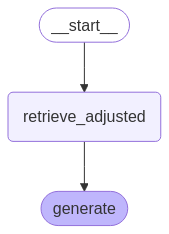

In [69]:
graph

In [70]:
G_in_rag = graph.invoke({"question" : "How are LLM agents useful?"})
G_in_rag["response"]

'LLM agents are useful primarily in two ways: as digital assistants that can act on behalf of users, akin to a travel agent, and as tools that can run loops to solve problems using programming capabilities. The context implies that LLMs excel at writing code, which is a significant application given the simpler grammar rules of programming languages compared to natural languages. However, there is skepticism regarding their overall utility due to concerns about gullibility—LLMs may struggle to distinguish truth from fiction, which limits their effectiveness in making meaningful decisions. Despite the excitement surrounding AI agents, there are few examples of them in production, indicating that their practical implementation is still evolving.'

In [71]:
import time

for test_row in dataset:
  response = graph.invoke({"question" : test_row.eval_sample.user_input})
  test_row.eval_sample.response = response["response"]
  test_row.eval_sample.retrieved_contexts = [context.page_content for context in response["context"]]
  time.sleep(2) # To try to avoid rate limiting.

In [72]:
adjusted_evaluation_dataset = EvaluationDataset.from_pandas(dataset.to_pandas())


In [73]:
result = evaluate(
    dataset=adjusted_evaluation_dataset,
    metrics=[LLMContextRecall(), Faithfulness(), FactualCorrectness(), ResponseRelevancy(), ContextEntityRecall(), NoiseSensitivity()],
    llm=evaluator_llm,
    run_config=custom_run_config
)
result

Evaluating:   0%|          | 0/72 [00:00<?, ?it/s]

Exception raised in Job[11]: AttributeError('StringIO' object has no attribute 'statements')


{'context_recall': 0.8278, 'faithfulness': 0.7934, 'factual_correctness': 0.6767, 'answer_relevancy': 0.8535, 'context_entity_recall': 0.5353, 'noise_sensitivity_relevant': 0.2071}

#### ❓ Question: 

Which system performed better, on what metrics, and why?

base_system: 
{'context_recall': 0.8448, 'faithfulness': 0.8650, 'factual_correctness': 0.6483, 'answer_relevancy': 0.7776, 'context_entity_recall': 0.5215, 'noise_sensitivity_relevant': 0.2188}

adjusted_system:
{'context_recall': 0.8278, 'faithfulness': 0.7934, 'factual_correctness': 0.6767, 'answer_relevancy': 0.8535, 'context_entity_recall': 0.5353, 'noise_sensitivity_relevant': 0.2071}


We made a change and some numbers affected positively. However, why it changed gear to negative direction  for context recal and faithfullness even if the brain is bigger and retriver is coherent!!

Base system is better at faithfully recalling the original context and being faithful to the source.

Adjusted system improved factual correctness (more accurate answers) and answer relevancy (more relevant answers), but sacrificed some faithfulness and context recall.

